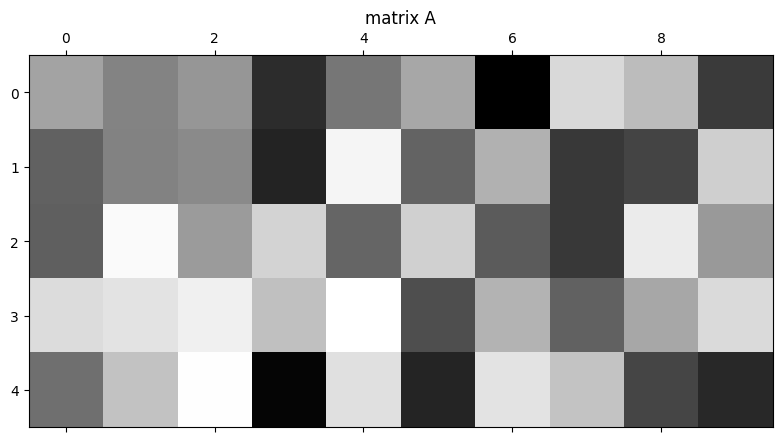

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
img1=np.random.randint(0,255,size=(5,10)) 
plt.matshow(img1, cmap='gray')
plt.title("matrix A")
plt.show()
plt.savefig('img.jpg')

In [5]:
import torch

graph_a = torch.load("./datasets/MultiTask_c03_id09/graphs_new/hetero_alphaonly_knn5_spatial4.5_sequential2_train_all/1A0A-A.pt")
graph_b = torch.load("./datasets/MultiTask_c03_id09/graphs_new/hetero_alphaonly_forhemenet_knn5_spatial4.5_sequential2_train_all/1A0A-A.pt")
graph_c = torch.load("./datasets/MultiTask_c03_id09/graphs_new/fullatom_knn9_spatial4.5_sequential2_train_all/1A0A-A.pt")

print(graph_a)
print(graph_b)
print(graph_c)

MyData(x=[63, 31], pos=[63, 1, 3], num_nodes=63, channel_weights=[63, 1], num_residues=63, chain=[63], edge_index=[2, 316], edge_relations=[316], edge_weights=[316], num_relation=6, affinities=[1, 2], functions=[1, 3293], valid_masks=[1, 4], chains=[63], lig_flag=[63], prot_id='1A0A-A', type='multi')
MyData(x=[498], edge_index=[2, 4305], pos=[498, 3], edge_weights=[4305], affinities=[1, 2], functions=[1, 3293], valid_masks=[1, 4], chains=[498], lig_flag=[498], prot_id='1A0A-A', type='multi')


In [6]:
i = 1
x = [1, 2, 3, 4, 5]
a = slice(-i)
b = slice(i, None)
print(a, b)
print(x[a])
print(x[b])

slice(None, -1, None) slice(1, None, None)
[1, 2, 3, 4]
[2, 3, 4, 5]


In [11]:
import json
import os
with open('./GMSL/datasets/MultiTask/uniformed_labels.json', 'r') as f:
    label_info = json.load(f)
graph_cache_dir = './GMSL/datasets/MultiTask_c03_id09/graphs_new/hetero_alphaonly_forhemenet_knn5_spatial4.5_sequential2_test'
complex_files = os.listdir(graph_cache_dir)
lba_complexes = []
ppi_complexes = []
for item in complex_files:
    if label_info[item[:-3]]['lba'] != -1:
        lba_complexes.append(item)
    elif label_info[item[:-3]]['ppi'] != -1:
        ppi_complexes.append(item)
print(len(lba_complexes), len(ppi_complexes))

452 15


In [13]:
import os
import time
import yaml
import wandb
import torch
import json
import os.path as osp
import pandas as pd

from argparse import ArgumentParser
from datetime import datetime
from typing import Optional

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from utils.task_models import MultiTaskModel, PropertyModel, AffinityModel
from utils.datamodule import GMSLDataModule

try:
    TEST_DIR = osp.join(osp.dirname(osp.realpath(__file__)), "tests")
except NameError:
    TEST_DIR = "./tests"

if not osp.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    
if __name__ == "__main__":
    # torch.multiprocessing.set_start_method('forkserver')
    torch.set_float32_matmul_precision('high')
    # args = get_argparse()
    # device = args.device
    device = [2]
    wandb_logger = None
        
    # if args.model_args['task'] == 'multi':
    #     model_cls = MultiTaskModel
    # elif args.model_args['task'] in ['ec', 'go', 'mf', 'bp', 'cc']:
    #     model_cls = PropertyModel
    # elif args.model_args['task'] == 'affinity':
    #     model_cls = AffinityModel
    
    model_cls = MultiTaskModel
    # if args.test_name is not None:
    #     model_dir = osp.join(TEST_DIR, args.test_name)
    # else:
    current_names = os.listdir(TEST_DIR)
    unamed_exps = [i[4:] for i in current_names if 'test' in i]
    if len(unamed_exps) > 0:
        largest = sorted(unamed_exps, key=int)
        current_num = str(int(largest[-1]) + 1)
    else:
        current_num = str(1)
    current_exp = 'test' + current_num
    model_dir = osp.join(TEST_DIR, current_exp)
    if not osp.exists(model_dir):
        os.makedirs(model_dir)

    datamodule = GMSLDataModule(
        batch_size=8,
        num_workers=4,
        train_split='train_all',
        val_split='val',
        test_split='test',
        cache_dir='./datasets/MultiTask_c03_id09/graphs_new/hetero_alphaonly_forhemenet_knn5_spatial4.5_sequential2',
        device='cuda' if device != 'cpu' else 'cpu',
        seed=817,
        task='multi'
    )

    model = model_cls.load_from_checkpoint(checkpoint_path='./models/hemenet_vallina/lightning_logs/version_18/checkpoints/last.ckpt', 
                                            hyp_path='./models/hemenet_vallina/lightning_logs/version_18/hparams.yaml',
                                            map_location=None,
                                           )
    print(
        f"Model consists of {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable params."
        )
    for name, parameter in model.named_parameters():
        print(name)
    trainer = pl.Trainer(devices=device if device != "cpu" else None,
            accelerator="gpu" if device != "cpu" else "cpu",)
    start_time = datetime.now()
    trainer.test(model=model, ckpt_path='./models/hemenet_vallina/lightning_logs/version_18/checkpoints/last.ckpt', dataloaders=datamodule, verbose=True)
    end_time = datetime.now()
    time_diff = end_time - start_time
    print(f"Testing time: {time_diff}")
    # Output the testing result
    res = model.res
    # with open(os.path.join(model_dir, "res.json"), "w") as f:
    #     json.dump(res, f)


Initializing MultiTask Model...
Readout Strategy: task_aware_attention


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model consists of 59798791 trainable params.
model.affinity_prompts
model.property_prompts
model.init_embedding.weight
model.channel_attr.weight
model.edge_attr.weight
model.gnn.layers.0.w_r
model.gnn.layers.0.batch_norm.weight
model.gnn.layers.0.batch_norm.bias
model.gnn.layers.0.radial_linear.weight
model.gnn.layers.0.radial_linear.bias
model.gnn.layers.0.hetero_linear.weight
model.gnn.layers.0.hetero_linear.bias
model.gnn.layers.0.message_mlp.0.weight
model.gnn.layers.0.message_mlp.0.bias
model.gnn.layers.0.message_mlp.2.weight
model.gnn.layers.0.message_mlp.2.bias
model.gnn.layers.0.coord_mlp.0.weight
model.gnn.layers.0.coord_mlp.0.bias
model.gnn.layers.0.coord_mlp.2.weight
model.gnn.layers.1.w_r
model.gnn.layers.1.batch_norm.weight
model.gnn.layers.1.batch_norm.bias
model.gnn.layers.1.radial_linear.weight
model.gnn.layers.1.radial_linear.bias
model.gnn.layers.1.hetero_linear.weight
model.gnn.layers.1.hetero_linear.bias
model.gnn.layers.1.message_mlp.0.weight
model.gnn.layers.1.mes

Restoring states from the checkpoint path at ./models/hemenet_vallina/lightning_logs/version_18/checkpoints/last.ckpt


Complexes for task multi is: 467


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at ./models/hemenet_vallina/lightning_logs/version_18/checkpoints/last.ckpt


Testing DataLoader 0:   0%|          | 0/59 [00:00<?, ?it/s]

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [24520, 14] but got: [24520, 1].